# Monte carlo simulation

In [1]:
import numpy as np 
import polars as pl 
from polars import col 
import matplotlib.pyplot as plt 
import seaborn as sb 
from dataclasses import dataclass

plt.style.use("../matplotlibrc")

In [13]:
@dataclass
class Preferences:
    gamma: float = 2.0
    gamma_low: float = 5.0
    subsistence: float = 30_000.0
    w_floor: float = 1_000.0
    bequest_param: float = 10.0
    rate_time_preference: float = 0.02


In [3]:
preferences = Preferences()

In [4]:
def get_matching_utility(*, subsistence: float, gamma: float, gamma_low: float):
    return crra_utility(subsistence, gamma=gamma) - crra_utility(
        subsistence, gamma=gamma_low
    )


def crra_utility(w: np.ndarray | float, *, gamma: float):
    """
    Interestingly, also known as the Box-Cox transformation in stats
    https://en.wikipedia.org/wiki/Isoelastic_utility
    """
    if abs(gamma - 1.0) < 1e-8:
        return np.log(w)
    return (1 - w ** (1 - gamma)) / (gamma - 1)


def composite_crra_utility(
    w: float,
    *,
    pref: Preferences,
    matching_utility: float | None = None,    
):
    """
    Piecewise CRRA:
    - If w < subsistence, treat as higher risk aversion gamma_subsistence.
    - If w < w_floor, it's all the same
    - Otherwise gamma as normal (e.g. 2).
    """
    if matching_utility is None:
        matching_utility = get_matching_utility(
            subsistence=pref.subsistence, gamma=pref.gamma, gamma_low=pref.gamma_low
        )
    if w < pref.w_floor:
        return crra_utility(pref.w_floor, gamma=pref.gamma_low) + matching_utility

    if w < pref.subsistence:
        return crra_utility(w, gamma=pref.gamma_low) + matching_utility
    else:
        return crra_utility(w, gamma=pref.gamma)

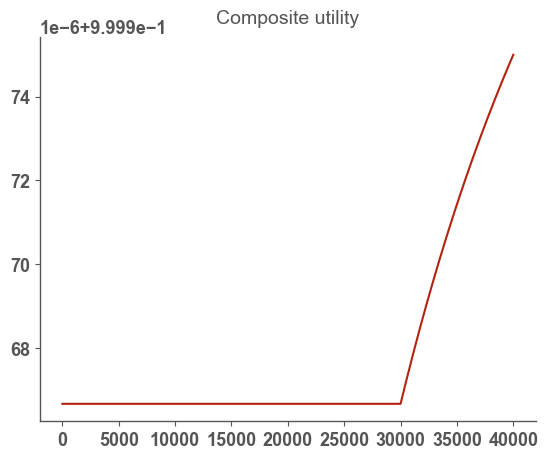

In [ ]:
w = np.linspace(0, 40e3, 1000)
u = np.array([composite_crra_utility(wi, pref=preferences) for wi in w])
fig, ax = plt.subplots()
ax.plot(w, u)
ax.set_title("Composite utility");

In [8]:
def bequest_utility(wealth, b=10, gamma=2.0):
    """
    U(Bequest) =  b * [ 1 - (W/b)^(1 - gamma ) ] / (gamma - 1)
    for example gamma=2, b=10, etc.
    """
    if wealth <= 0:
        return 0.0  # or negative utility, but typically 0 is fine if no wealth
    # If gamma=2 => b * [1 - (W/b)^(-1)] / (1)
    # More general:
    return b * (1 - (wealth / b)**(1 - gamma)) / (gamma - 1)

In [9]:
# Got this from chatGPT, but looks sensible. Think more later.
def draw_lognormal_return(mean_return=0.09, stdev=0.20, n_sims=1):    
    # Draw from normal with mean=mean_return, stdev=stdev,
    # then do (1 + normal_draw).
    # But that can lead to negative returns. Let's do a direct lognormal approach:
    
    # We want to produce returns R >= -100%.
    # Usually we do: R = exp(X) - 1, where X ~ Normal(m, s^2).
    # E[R] = E[exp(X) - 1] = exp(m + s^2/2) - 1.
    
    # So set exp(m + s^2/2) - 1 = mean_return => m + s^2/2 = ln(1 + mean_return).
    
    sigma_log = np.sqrt(np.log(1 + (stdev**2 / (1+mean_return)**2)))  # approximate
    mu_log = np.log(1 + mean_return) - 0.5 * sigma_log**2
    
    # Now draw X ~ Normal(mu_log, sigma_log^2), then R = exp(X)-1
    X = np.random.normal(loc=mu_log, scale=sigma_log, size=n_sims)
    R = np.exp(X) - 1.0
    return R

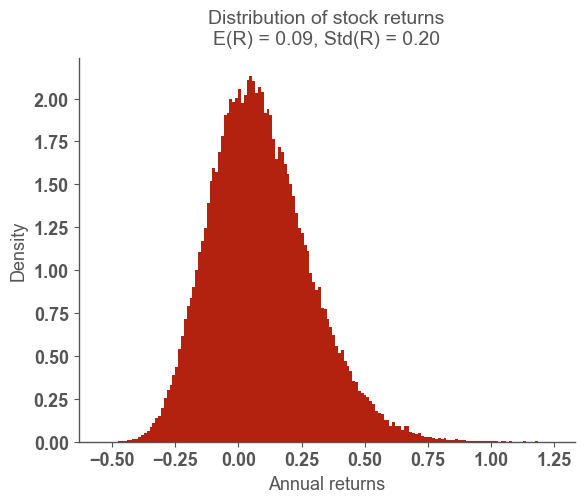

In [10]:
stock_returns = draw_lognormal_return(n_sims=100_000)
fig, ax = plt.subplots()
ax.hist(stock_returns, bins="auto", density=True)
stock_returns_mean = stock_returns.mean()
stock_returns_std = stock_returns.std()
ax.set_xlabel("Annual returns")
ax.set_ylabel("Density")
ax.set_title(
    f"Distribution of stock returns\nE(R) = {stock_returns_mean:.2f}, Std(R) = {stock_returns_std:.2f}"
);

In [14]:
@dataclass
class Policy:
    consumption_fraction: float 
    risky_asset_fraction_tax_free: float 
    risky_asset_fraction_taxable: float 

@dataclass
class RiskyAsset:
    expected_excess_return: float 
    standard_deviation: float

In [15]:
def wealth_to_gamma(
    w: float, *, subsistence: float, gamma_low: float, gamma: float
) -> float:
    if w < subsistence:
        return gamma_low
    return gamma

def merton_share(risky_asset: RiskyAsset, gamma: float):
    return risky_asset.expected_excess_return / (gamma * risky_asset.standard_deviation**2) 

In [16]:
def optimal_consumption_infinite_horizon(
    *, return_risk_adjusted: float, rate_time_preference: float, gamma: float
):
    return return_risk_adjusted - (return_risk_adjusted - rate_time_preference) / gamma


def optimal_consumption_finite_horizon(
    *,
    return_risk_adjusted: float,
    rate_time_preference: float,
    gamma: float,
    horizon_years: int,
    risky_asset: RiskyAsset,
):
    c_infty = optimal_consumption_infinite_horizon(
        return_risk_adjusted=return_risk_adjusted,
        rate_time_preference=rate_time_preference,
        gamma=gamma,
    )

    return c_infty / (1 - (1 + c_infty) ** (-horizon_years))


def policy(
    horizon_years: int,
    w: float,
    pref: Preferences,
    return_risk_adjusted_portfolio: float,
    risky_asset: RiskyAsset,
) -> Policy:
    this_gamma = wealth_to_gamma(
        w, subsistence=pref.subsistence, gamma_low=pref.gamma_low, gamma=pref.gamma
    )
    consumption_fraction = optimal_consumption_finite_horizon(
        return_risk_adjusted=return_risk_adjusted_portfolio,
        rate_time_preference=pref.rate_time_preference,
        gamma=this_gamma,
        horizon_years=horizon_years,
    )

    risky_asset_fraction_tax_free = merton_share(risky_asset, this_gamma)
    risky_asset_fraction_taxable = merton_share(risky_asset, this_gamma)

    return Policy(
        consumption_fraction=consumption_fraction,
        risky_asset_fraction_tax_free=risky_asset_fraction_tax_free,
        risky_asset_fraction_taxable=risky_asset_fraction_taxable,
    )